In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import collections
import glob
from skimage import img_as_ubyte

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


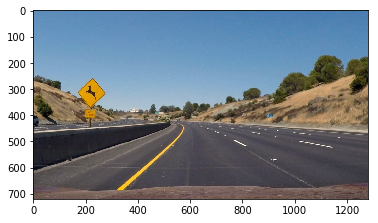

In [3]:
# reading an image
tester_image = mpimg.imread('test_images/test2.jpg')

#printing out some stats and plotting
print('This image is:', type(tester_image), 'with dimensions:', tester_image.shape)
plt.imshow(tester_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### Camera Calibration


20 (720, 1280, 3)


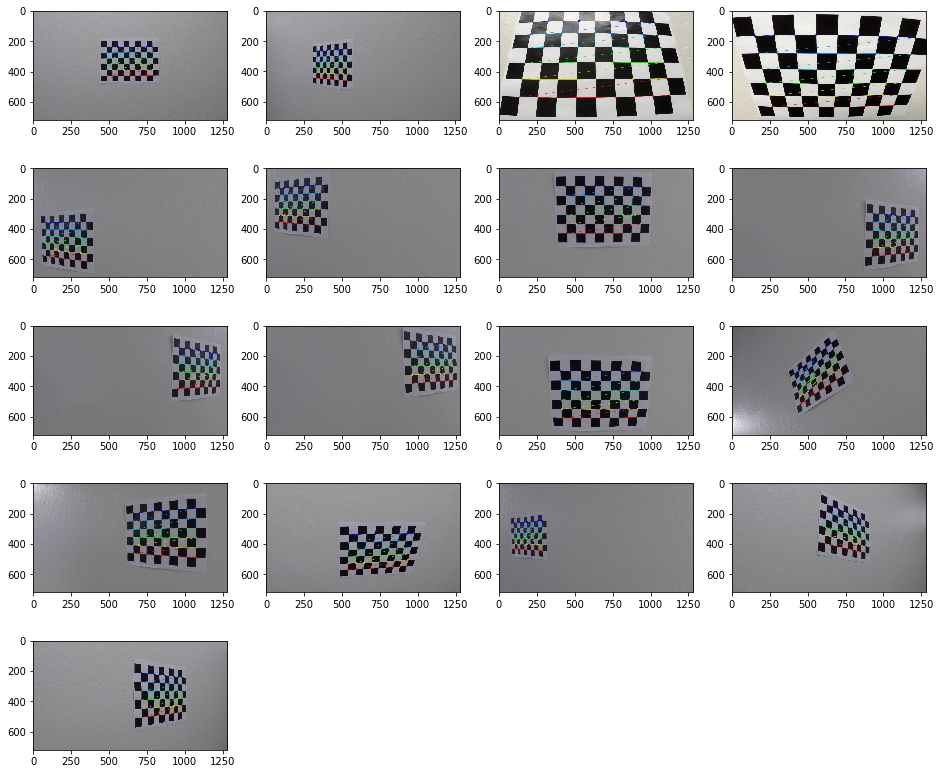

In [4]:
#Read calibration images
camera_cal_location = glob.glob('camera_cal/*.jpg')
test_image_location = glob.glob('test_images/*.jpg')
cal_images = []
nx = 9
ny = 6
count = 0
for f in camera_cal_location:
    img = mpimg.imread(f)
    cal_images.append(img)
    
print(len(cal_images), cal_images[0].shape)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
plt.figure(figsize=(16, 14))
for image in cal_images:
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img_cor =  cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.subplot(5, 4, count+1)
        plt.imshow(img_cor)
        count += 1

Text(0.5,1,'Undistorted Image')

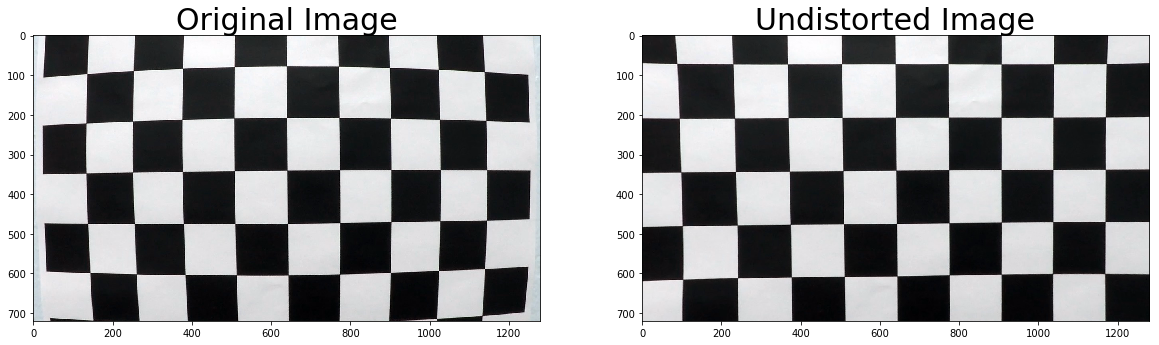

In [5]:
import  pickle

# Test undistortion on an image  
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./output_images/camera_mtx_dist.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
def load_camera_cal_params(pickle_fname):
    """ Loads from a pickle file the camera
        distortion matrix and distances.

    Parameter:
        - pickle_fname: Pickle file name.
    Returns:
        - (mtx, dist) tuple.
    """
    with open(pickle_fname, "rb") as pf:
        data = pickle.load(pf)
        return data['mtx'], data['dist']

pickle_fname = './output_images/camera_mtx_dist.p'
mtx, dist = load_camera_cal_params(pickle_fname)

assert mtx is not None
assert mtx.shape == (3,3)
assert dist is not None

print("The camera calibration mtx and dist are loaded!")

The camera calibration mtx and dist are loaded!


True

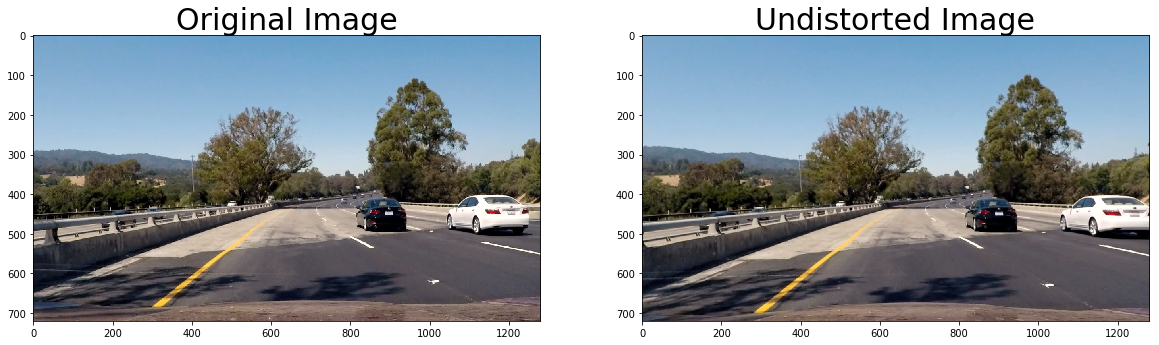

In [7]:
def pipeline_undistort(img, mtx, dist):
    """ Undistorts the input image. """
    return cv2.undistort(img, mtx, dist, None, mtx)
img_fname = './test_images/test4.jpg'
img = cv2.imread(img_fname)
img_undist = pipeline_undistort(img, mtx, dist)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # only for display reason
img_undist= cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB) # only for display reason


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=30)

cv2.imwrite('./output_images/test4_undist.jpg',img_undist)

True

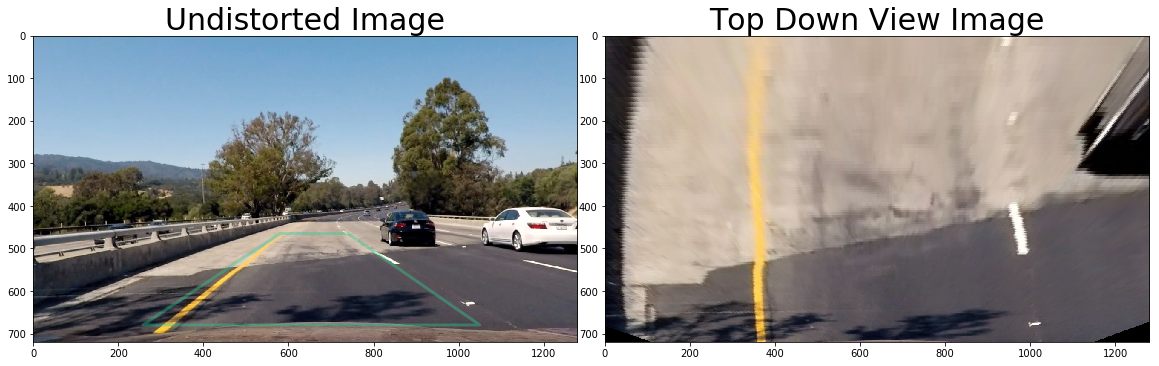

In [27]:

def  top_down_view(img):
    """ 
    Apply perspective transformation on input image.
    Returns: The transformed input image with top down view as uint8 type.
    
    """
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    undist = pipeline_undistort(img, mtx, dist)
    h,w = undist.shape[:2]
    # define source and destination points for transform
    src = np.float32([(580,465),
                  (740,465), 
                  (258,680), 
                  (1050,680)])
    dst = np.float32([(320,0),
                  (w-320,0),
                  (320,h),
                  (w-320,h)])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_NEAREST)
    return img_as_ubyte(warped), M

img_warped, M = top_down_view(img_undist)

# Visualize undistortion
src = np.float32([(575,460), (260,680), (705,460), (1050,680)])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
src = np.float32([(580,465),(740,465), (258,680), (1050,680)])

f.subplots_adjust(hspace = .2, wspace=.05)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.imshow(img_undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(img_warped)
ax2.set_title('Top Down View Image', fontsize=30)

cv2.imwrite('./output_images/test4_warped.jpg',img_warped)

True

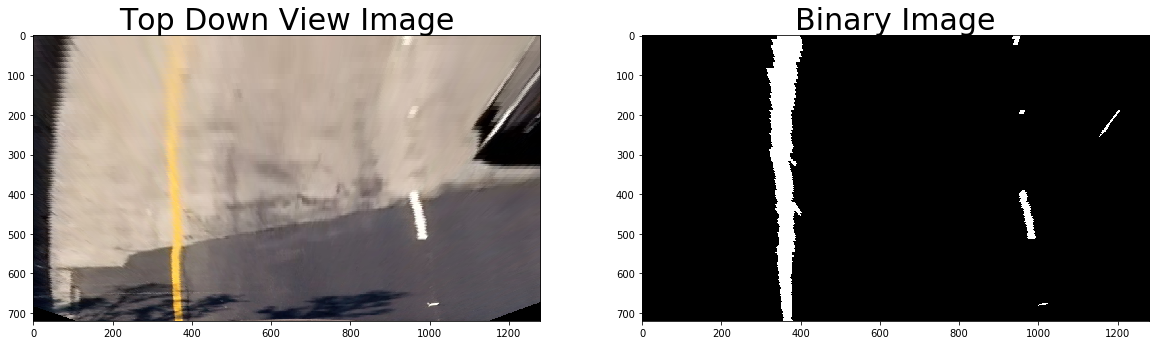

In [28]:
def  binary_trans(img):
    """ Given an input image it convert the image color space
        from RGB to HLS, tekes only the S channel and applies
        Sobel thresholding along X axis.

        Returns: a color binary image with only those pixels
        set to 1 iff the Sobel values were within the sx_thresh
    """
    

    img = np.copy(img)
    
                                                     
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,1]
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 145
    b_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 220
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    flat_binary = np.zeros_like(s_binary)
    flat_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return flat_binary

img_binary = binary_trans(img_warped)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_warped)
ax1.set_title('Top Down View Image', fontsize=30)
ax2.imshow(img_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

cv2.imwrite('./output_images/test4_warped_binary.jpg',img_binary)

True

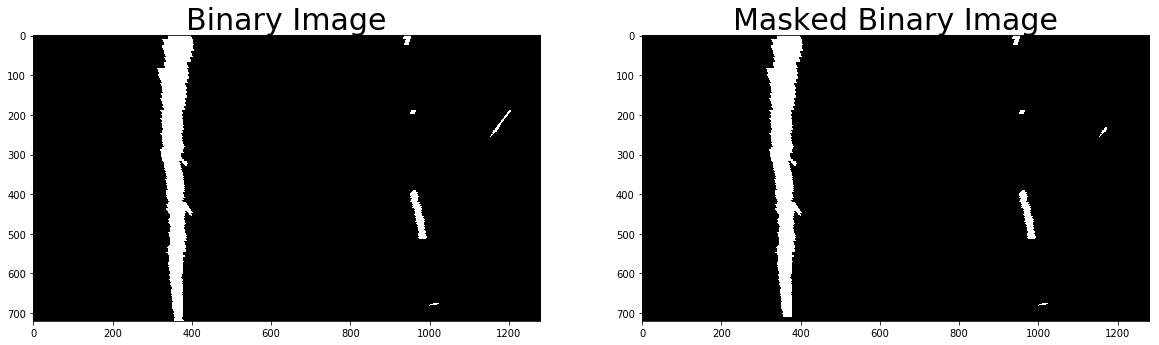

In [29]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(120, 710),(160, 0), (1150, 0), (1210,710)]], dtype=np.int32) #160-280
masked_binary = region_of_interest(img_binary, vertices)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_binary, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(masked_binary, cmap='gray')
ax2.set_title('Masked Binary Image', fontsize=30)

cv2.imwrite('./output_images/test4_masked_binary.jpg',img_binary)

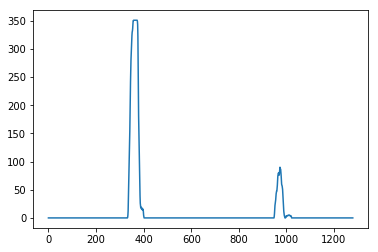

In [30]:
def plot_hist(img, axis = 0):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    return histogram

img_binary = masked_binary
histogram = plot_hist(img_binary)

(720, 0)

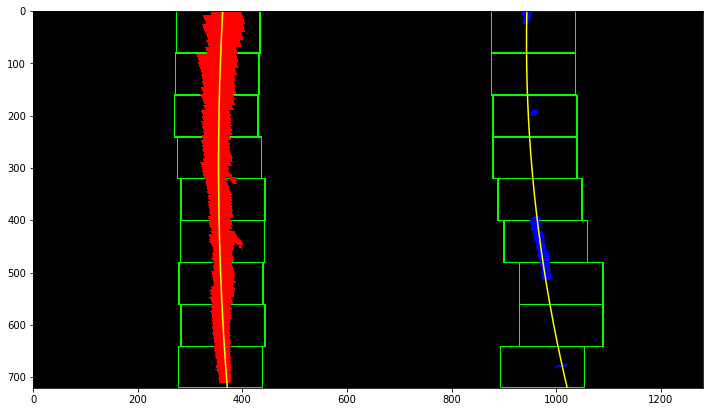

In [31]:
def findlines(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((img_binary, img_binary, img_binary))*0
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    

    ### plot the figures
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #print(y_eval)
    
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #print(left_curverad, right_curverad, np.mean([left_curverad, right_curverad]))
    
    # Compute car position
    h = binary_warped.shape[0]
    m_car = binary_warped.shape[1] / 2
    
    l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        
    #m_lane = (left_fitx[y_eval] + right_fitx[y_eval]) / 2
    center_dist = (m_car - lane_center_position) * xm_per_pix
    #offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    #print(m_car,lane_center_position )
    return out_img, avg_radius_meters, center_dist, left_fitx, right_fitx, ploty
    
    
img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = findlines(img_binary)


plt.figure(figsize=(12, 8))     
plt.imshow(img_lines)
plt.plot(l_fit, ploty, color='yellow')
plt.plot(r_fit, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [32]:
def findlines_after(binary_warped):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
  
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    # Compute car position
    m_car = binary_warped.shape[1] / 2
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty

In [33]:

def  to_real_world_scale(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,255))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,50,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,50,0), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result


Minv = np.linalg.inv(M)
final_output = to_real_world_scale(img, img_lines, Minv, l_fit, r_fit, ploty)

Text(0.5,1,'Final Image')

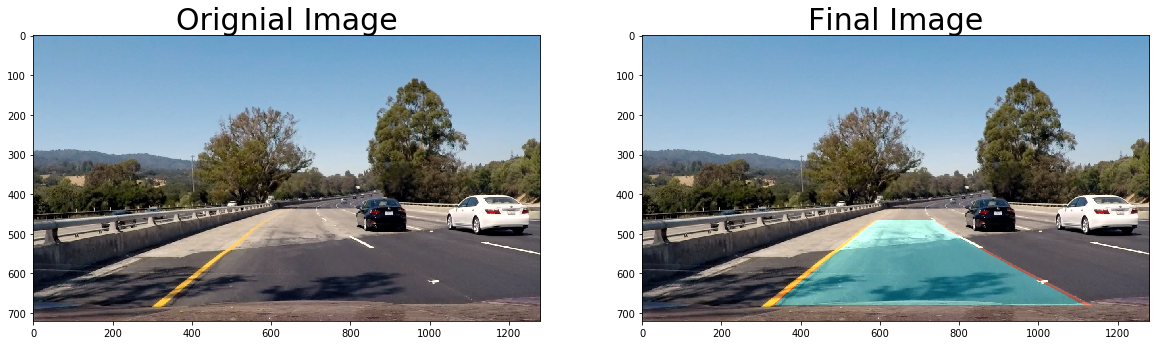

In [34]:
f,  (ax1,  ax2)=  plt.subplots(1, 2, figsize=(20,15))
ax1.imshow(img)
ax1.set_title('Orignial Image', fontsize=30)
ax2.imshow(final_output)
ax2.set_title('Final Image', fontsize=30)

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
def process_image(input_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    ksize = 9
    d_thresh  = (0.7, 1.2)
    sc_thresh=(110, 255)
    sx_thresh=(20, 100)
    
    img_undist = pipeline_undistort(input_image, mtx, dist)
    warped, M = top_down_view(img_undist)
    binary = binary_trans(warped)
    vertices = np.array([[(110, 690),(110, 0), (1150, 0), (1200,690)]], dtype=np.int32)
    masked_binary = region_of_interest(binary, vertices)
    total_binary = binary_trans(img_undist)
    
    img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = findlines(masked_binary)
    img_out, r_meters, right_from_center_m, l_fit, r_fit, ploty = findlines(binary)
    
    # ==============  smoothing  ==============
    # Update the RingBuffer
    global l_fit_buffer
    global r_fit_buffer
    global old_img_lines

    if old_img_lines is None:
        old_img_lines = binary

    ret = cv2.matchShapes(old_img_lines, binary, 1, 0.0)
    #print(ret)
    if ret < 50:
        old_img_lines = binary

        if l_fit_buffer is None:
            l_fit_buffer = np.array([l_fit])

        if r_fit_buffer is None:
            r_fit_buffer = np.array([r_fit])

        l_fit_buffer = np.append(l_fit_buffer, [l_fit], axis=0)[-FILTER_SIZE:]
        r_fit_buffer = np.append(r_fit_buffer, [r_fit], axis=0)[-FILTER_SIZE:]
    
    # Compute the mean
    l_fit_mean = np.mean(l_fit_buffer, axis=0)
    r_fit_mean = np.mean(r_fit_buffer, axis=0)
    

    # Warp back to original scale
    Minv = np.linalg.inv(M)
    final_output = to_real_world_scale(input_image, img_lines, Minv, l_fit_mean, r_fit_mean, ploty)
    
    
    img_h = input_image.shape[0]
    img_w = input_image.shape[1]
    img_size = (img_w, img_h)
    
    small_img = cv2.resize(img_out, (img_size[0]//4, img_size[1]//4))
    small_binary = cv2.resize(total_binary, (img_size[0]//4, img_size[1]//4))
    small_gray = np.zeros_like(small_img)
    small_gray[:,:,0] = small_binary*255
    small_gray[:,:,1] = small_binary*255
    small_gray[:,:,2] = small_binary*255
    x_offset=25
    y_offset=25
    final_output[y_offset:y_offset+small_img.shape[0], x_offset:x_offset+small_img.shape[1]] = small_img
    x_offset=  img_size[0] - 25 - img_size[0]//4
    final_output[y_offset:y_offset+small_binary.shape[0], x_offset:x_offset+small_binary.shape[1]] = small_gray
    
    
    
    
    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature of the Lane: {:.0f} m".format(r_meters)
    cv2.putText(final_output, text, (380,img_size[1]//8), font, 0.8, (255,255,255), 2)
    text = "Veh Offset to right from center {:.2f} m".format(right_from_center_m)
    cv2.putText(final_output, text, (380,img_size[1]//4), font, 0.8, (255,255,255), 2)
    
    #return np.hstack((final_output, img_lines))
    final_output = np.array(final_output)
    return final_output

Text(0.5,1,'Final Output')

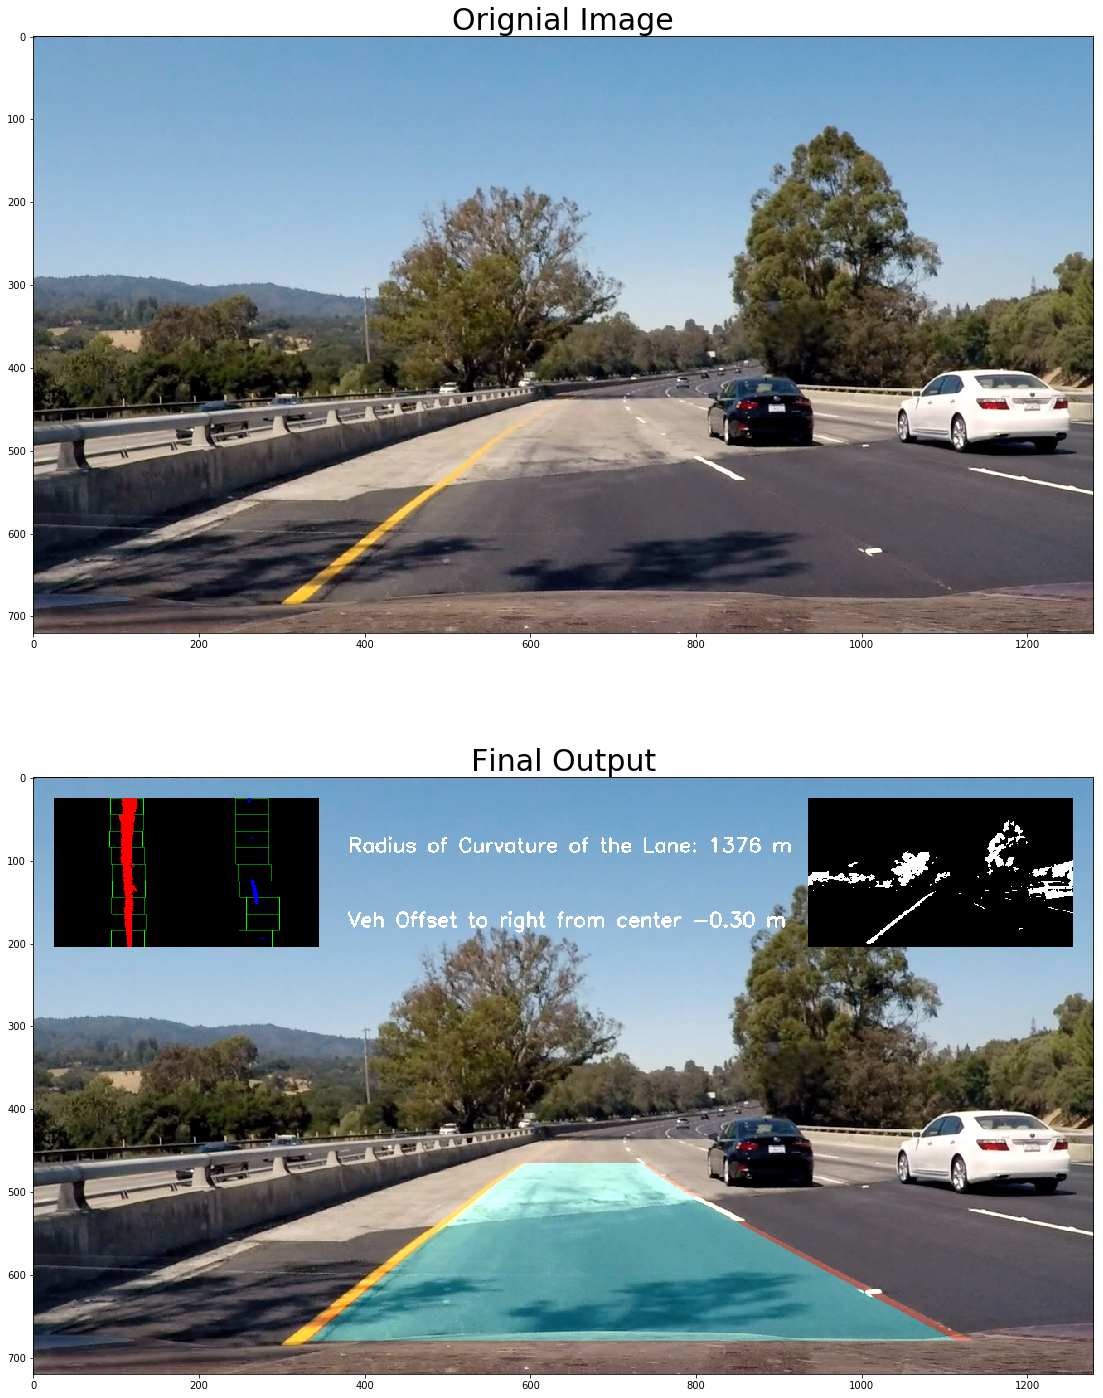

In [37]:

FILTER_SIZE = 20
old_img_lines = None
l_fit_buffer = None
r_fit_buffer = None

r = process_image(img)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(19,25))
ax1.imshow(img)
ax1.set_title('Orignial Image', fontsize=30)
ax2.imshow(r)
ax2.set_title('Final Output', fontsize=30)

In [38]:
project_video_output = "./output_video/project_video_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/project_video_output.mp4
[MoviePy] Writing video ./output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:16<00:00,  6.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video_output.mp4 

CPU times: user 13min 52s, sys: 26.5 s, total: 14min 18s
Wall time: 3min 17s


In [39]:
challenge_video_output  = "./output_video/challenge_video_output.mp4"
clip2 = VideoFileClip("./challenge_video.mp4")
white_clip2 = clip2.fl_image(process_image)
%time white_clip2.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/challenge_video_output.mp4
[MoviePy] Writing video ./output_video/challenge_video_output.mp4


  1%|          | 5/485 [00:00<01:06,  7.27it/s]

TypeError: expected non-empty vector for x